# Step 1: Identifying Potential Xylanase Sequences
In this step, We will:
1. Install and configure BLAST+
2. Download the reference thermostable xylanase sequences
3. Run BLAST to find similar sequences
4. Extract significant hits

### 1. Install BLAST+ (if not already installed)

In [1]:
!conda install -c bioconda blast -y

Channels:
 - bioconda
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



### 2. Download Reference Xylanase Sequences
Download the reference xylanase sequences from the provided Google Drive link. We have already downloaded the dataset manually.

In [ ]:
!pip install gdown
!gdown --id 1-dDyIdAXKUK97rxw_n4zE_gzh2fztFRU

### 3. Format the Reference Database

In [7]:
!makeblastdb -in data/thermo_xylanase.fasta -dbtype prot -out xylanase_db



Building a new DB, current time: 02/07/2025 18:52:31
New DB name:   /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
New DB title:  data/thermo_xylanase.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 11 sequences in 0.000927925 seconds.




### 3.1 Run BLASTN to Identify Similar Contigs


In [8]:
!blastx -query data/y5.final.contigs.fa -db xylanase_db -out step1/blast_results.txt -evalue 1e-5 -outfmt 6

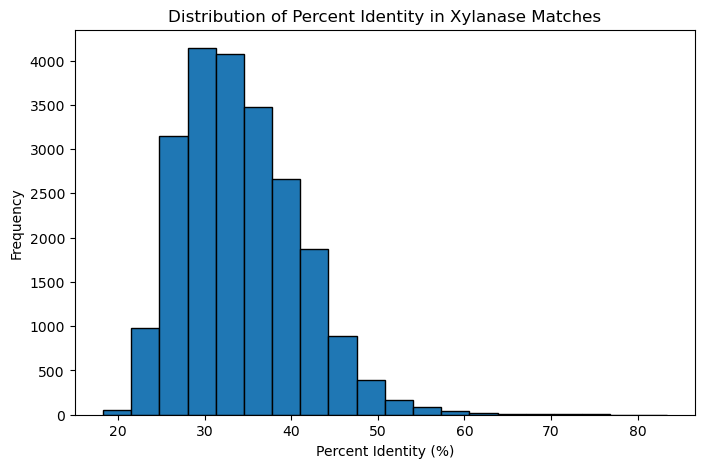

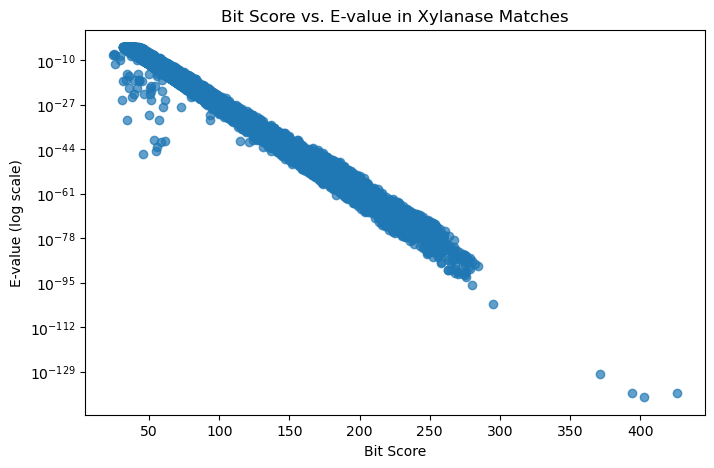

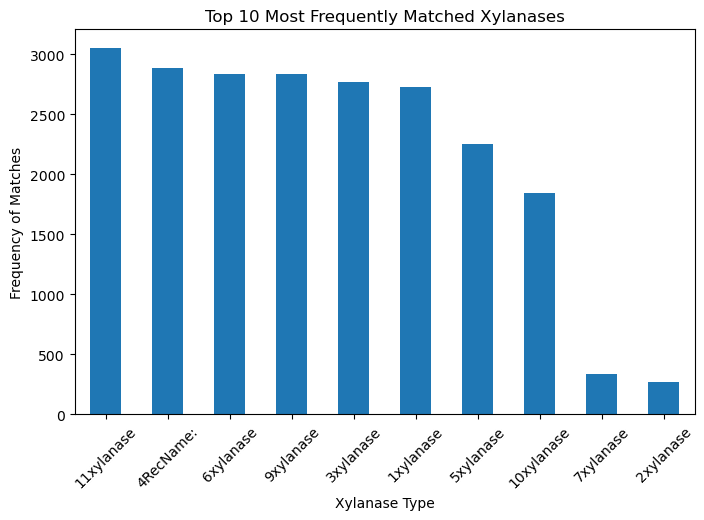

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the provided results.txt
file_path = "step1/blast_results.txt"

# Define column names based on BLAST-like output format
columns = ["Contig", "Matched_Xylanase", "Percent_Identity", "Alignment_Length", "Mismatches",
           "Gap_Openings", "Query_Start", "Query_End", "Subject_Start", "Subject_End",
           "E_value", "Bit_Score"]

# Read the data
df = pd.read_csv(file_path, sep="\t", names=columns)

# Convert necessary columns to numeric types
df["Percent_Identity"] = pd.to_numeric(df["Percent_Identity"], errors='coerce')
df["E_value"] = pd.to_numeric(df["E_value"], errors='coerce')
df["Bit_Score"] = pd.to_numeric(df["Bit_Score"], errors='coerce')


# Plot 1: Distribution of Percent Identity
plt.figure(figsize=(8, 5))
plt.hist(df["Percent_Identity"], bins=20, edgecolor='black')
plt.xlabel("Percent Identity (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Percent Identity in Xylanase Matches")
plt.savefig("images/percent_identity_dist.png")
plt.show()

# Plot 2: Scatter plot of Bit Score vs. E-value (log scale)
plt.figure(figsize=(8, 5))
plt.scatter(df["Bit_Score"], df["E_value"], alpha=0.7)
plt.yscale("log")  # Log scale for better visibility
plt.xlabel("Bit Score")
plt.ylabel("E-value (log scale)")
plt.title("Bit Score vs. E-value in Xylanase Matches")
plt.savefig("images/bit_score_evalue.png")
plt.show()

# Plot 3: Most Frequently Matched Xylanases
top_xylanases = df["Matched_Xylanase"].value_counts().head(10)
plt.figure(figsize=(8, 5))
top_xylanases.plot(kind="bar")
plt.xlabel("Xylanase Type")
plt.ylabel("Frequency of Matches")
plt.title("Top 10 Most Frequently Matched Xylanases")
plt.xticks(rotation=45)
plt.savefig("images/top_matches.png")
plt.show()


### 3.2. DIAMOND BLASTX (Faster than BLAST)

In [ ]:
!conda install -c bioconda diamond -y

In [126]:
!diamond makedb --in data/thermo_xylanase_aligned.fasta -d xylanase_db

diamond v2.1.10.164 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 12
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: data/thermo_xylanase_aligned.fasta
Opening the database file...  [0s]
Loading sequences...  [0s]
Masking sequences...  [0.003s]
Writing sequences...  [0s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  11
  Database letters  12408
     Database hash  ef7b5b85c1b882aac3ffeae765bc68e7
        Total time  0.005000s


In [129]:
!diamond blastx -d xylanase_db.dmnd -q data/y5.final.contigs.fa -o step1/diamond_output.tsv --outfmt 6 --sensitive --evalue 1e-5

diamond v2.1.10.164 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 12
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: step1
#Target sequences to report alignments for: 25
Opening the database...  [0s]
Database: xylanase_db.dmnd (type: Diamond database, sequences: 11, letters: 12408)
Block size = 2000000000
Opening the input file...  [0.091s]
Opening the output file...  [0s]
Loading query sequences... 

### 3.3. HMMER Search (Profile-based Similarity)
HMMER uses profile Hidden Markov Models (HMMs), which are better for detecting remote homologs.
It looks like there may be invalid characters in the FASTA sequence. I'll clean the file by Removing any tab characters, Removing empty lines, Ensuring only valid amino acid characters are used.

In [ ]:
# import re
# 
# # Define valid amino acid characters and allowed symbols
# valid_chars = re.compile(r"^[ACDEFGHIKLMNPQRSTVWYBXZ\-]+$")
# 
# # Clean the FASTA file
# cleaned_fasta = []
# for line in fasta_content:
#     line = line.strip()  # Remove leading/trailing whitespace
#     if line.startswith(">"):  # Keep headers unchanged
#         cleaned_fasta.append(line)
#     elif line:  # Ignore empty lines
#         # Remove invalid characters (e.g., tabs) and check sequence validity
#         line = line.replace("\t", "").upper()
#         if valid_chars.match(line):
#             cleaned_fasta.append(line)
#         else:
#             print(f"Warning: Skipping line due to invalid characters - {line}")
# 
# # Save the cleaned file
# cleaned_file_path = "data/thermo_xylanase_cleaned.fasta"
# with open(cleaned_file_path, "w") as f:
#     f.write("\n".join(cleaned_fasta) + "\n")

HMMER expects an aligned FASTA file (i.e., all sequences should be of equal length)

In [24]:
!clustalo -i data/thermo_xylanase_cleaned.fasta -o data/thermo_xylanase_aligned.fasta --force

Now, First, we create an HMM profile from our known sequences:

In [25]:
!hmmbuild xylanase.hmm data/thermo_xylanase_aligned.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             data/thermo_xylanase_aligned.fasta
# output HMM file:                  xylanase.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     thermo_xylanase_aligned    11  1128   799     2.15  0.589 

# CPU time: 0.32u 0.00s 00:00:00.32 Elapsed: 00:00:00.32


Now, search the contigs against this HMM model:

Since hmmsearch cannot handle long sequences, we need to break the y5.final.contigs.fa file into smaller chunks before running hmmsearch. We can use seqkit for this.

In [28]:
!seqkit sliding -s 50000 -W 50000 -o data/y5_splitted.fa data/y5.final.contigs.fa

Searches for xylanase-like sequences in the split metagenomic contigs.

In [32]:
!hmmsearch --tblout step1/hmm_results.txt xylanase.hmm data/y5_splitted.fa

Failed to parse command line: No such option "--E".
Usage: hmmsearch [options] <hmmfile> <seqdb>

where most common options are:
  -h : show brief help on version and usage

To see more help on available options, do hmmsearch -h



### 4. Filter Results Based on Similarity
After running all three searches, we extract contigs that have significant similarity. From now on, we just use the results of BLAST+.

In [13]:
import pandas as pd

# Load BLASTX results (assuming the file is tab-separated)
blastx_df = pd.read_csv("step1/blast_results.txt", sep="\t", header=None)

# Assign column names based on BLASTX output format
blastx_df.columns = ["Query_ID", "Subject_ID", "%_Identity", "Alignment_Length", 
                     "Mismatches", "Gap_Openings", "Query_Start", "Query_End", 
                     "Subject_Start", "Subject_End", "E-value", "Bit_Score"]
# Define thresholds
identity_threshold = 30   # Keep sequences with at least 30% identity
alignment_length_threshold = 50  # Keep sequences with at least 50 aligned amino acids
evalue_threshold = 1e-5   # Remove weak matches (higher E-value means lower significance)
bit_score_threshold = 50  # Keep strong alignments

# Apply filtering
filtered_df = blastx_df[
    (blastx_df["%_Identity"] >= identity_threshold) &
    (blastx_df["Alignment_Length"] >= alignment_length_threshold) &
    (blastx_df["E-value"] <= evalue_threshold) &
    (blastx_df["Bit_Score"] >= bit_score_threshold)
]

# Save filtered results
filtered_df.to_csv("step1/filtered_results.txt", sep="\t", index=False)

### 5. Extract & Translate Candidate Contigs

In [14]:
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq

# Load the filtered BLASTX results
filtered_blastx_df = pd.read_csv("step1/filtered_results.txt", sep="\t")

# Extract the contig IDs that passed the filtering
filtered_contigs = set(filtered_blastx_df["Query_ID"])  # Unique contig IDs

#### Extract Nucleotide Sequences from Dataset

In [16]:
# Load the assembled contigs file (nucleotide sequences)
contig_file = "data/y5.final.contigs.fa"  # Change this to your actual filename

# Read the nucleotide sequences and store only the filtered ones
filtered_sequences = {}

for record in SeqIO.parse(contig_file, "fasta"):
    if record.id in filtered_contigs:  # Keep only sequences that passed filtering
        filtered_sequences[record.id] = record.seq

# Save extracted sequences to a new FASTA file
with open("step1/filtered_contigs.fasta", "w") as output_fasta:
    for contig_id, seq in filtered_sequences.items():
        output_fasta.write(f">{contig_id}\n{seq}\n")


#### Translate Nucleotide Sequences to Protein

In [19]:
# Translate the filtered nucleotide sequences
translated_sequences = {}

for contig_id, seq in filtered_sequences.items():
    translated_seq = Seq(str(seq)).translate(to_stop=True)  # Stop at first stop codon
    translated_sequences[contig_id] = translated_seq

# Save translated sequences to a FASTA file
with open("step1/translated_proteins.fasta", "w") as output_fasta:
    for contig_id, protein_seq in translated_sequences.items():
        output_fasta.write(f">{contig_id}\n{protein_seq}\n")

/home/amir/miniconda3/lib/python3.12/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


#### Using Commands
Also, We can do it using the Seqtk and TRANSEQ 

In [23]:
!conda install -c bioconda seqtk -y

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/amir/miniconda3

  added / updated specs:
    - seqtk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    seqtk-1.4                  |       he4a0461_2          43 KB  bioconda
    ------------------------------------------------------------
                                           Total:          43 KB

The following NEW packages will be INSTALLED:

  seqtk              bioconda/linux-64::seqtk-1.4-he4a0461_2 



                                                                                
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [3]:
# Extract potential contig sequences
!seqtk subseq data/y5.final.contigs.fa step1/filtered_results.txt > step1/potential_xylanase_contigs.fasta

In [29]:
!conda install -c bioconda emboss -y

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/amir/miniconda3

  added / updated specs:
    - emboss


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    emboss-6.6.0               |       h6debe1e_0        94.5 MB  bioconda
    libgd-2.3.3                |       h695aa2c_1         222 KB
    ------------------------------------------------------------
                                           Total:        94.7 MB

The following NEW packages will be INSTALLED:

  emboss             bioconda/linux-64::emboss-6.6.0-h6debe1e_0 
  libgd              pkgs/main/linux-64::libgd-2.3.3-h695aa2c_1 



emboss-6.6.0         | 94.5 MB   |                                       |   0% 
libgd-2.3.3          | 222 KB    |                                       |   0% 
libgd-2.3.3          | 222 KB    | ##6                  

In [6]:
# Translate contigs into protein sequences
!transeq step1/potential_xylanase_contigs.fasta -outseq step1/potential_xylanase_proteins.fa

Translate nucleic acid sequences


In [36]:
from Bio import SeqIO

# Load the extracted sequences
extracted_sequences = list(SeqIO.parse("step1/potential_xylanase_contigs.fasta", "fasta"))

# Display the first few sequences
for i, record in enumerate(extracted_sequences[:5]):  # Display first 5 sequences
    print(f"Sequence ID: {record.id}")
    print(f"Sequence: {record.seq}")
    print(f"Length: {len(record.seq)}")
   

Sequence ID: k141_960819:12-44
Sequence: TGAAATAAAAGGTGATTCTAGTACTGTTGATGA
Length: 33
Sequence ID: k141_3842622:12-34
Sequence: GGGAGGCTCAGCACGACTGATTT
Length: 23
Sequence ID: k141_3842622:10-30
Sequence: CTGGGAGGCTCAGCACGACTG
Length: 21
Sequence ID: k141_3842622:5-32
Sequence: CTTTGCTGGGAGGCTCAGCACGACTGAT
Length: 28
Sequence ID: k141_3842622:2-30
Sequence: ATGCTTTGCTGGGAGGCTCAGCACGACTG
Length: 29


#### (Optional) Machine learning-based approach


In [ ]:
# !pip install scikit-learn biopython
# from Bio import SeqIO
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# known_xylanases = list(SeqIO.parse("thermo_xylanase.fasta", "fasta"))
# known_sequences = [str(record.seq) for record in known_xylanases]
# vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3))
# X_known = vectorizer.fit_transform(known_sequences)
# potential_sequences = list(SeqIO.parse("potential_xylanase_proteins.fa", "fasta"))
# potential_sequences = [str(record.seq) for record in potential_sequences]
# X_potential = vectorizer.transform(potential_sequences)
# from sklearn.linear_model import LogisticRegression
# y_known = np.ones(len(known_sequences))
# model = LogisticRegression()
# model.fit(X_known, y_known)
# predictions = model.predict(X_potential)
# predicted_xylanases = [potential_sequences[i] for i in range(len(potential_sequences)) if predictions[i] == 1]
# with open("predicted_xylanase_sequences.fa", "w") as f:
#     for i, seq in enumerate(predicted_xylanases):
#         f.write(f">predicted_xylanase_{i}\n{seq}\n")

# Step 2: Clustering and Representative Sequence Selection
Now that we have identified potential xylanase sequences, we need to:
1. Cluster highly similar sequences using CD-HIT.
2. Select representative sequences from each cluster.


### 1. Install CD-HIT (if not already installed)

In [ ]:
!conda install -c bioconda cd-hit -y

### 2. Running CD-HIT to Cluster Protein Sequences
CD-HIT clusters sequences based on similarity thresholds. Here, we use 97% identity to group similar xylanase sequences.
Explanation of Parameters:
- i translated_proteins.fasta → Input file (from Step 1).
- o clustered_xylanase.fasta → Output file (clustered sequences).
- c 0.97 → 97% similarity threshold.
- n 5 → Word size for clustering (recommended for protein sequences).
- d 0 → No description in output, keeping it compact.

In [98]:
def get_sequence_lengths(fasta_file):
    lengths = []
    with open(fasta_file, "r") as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    lengths.append(len(seq))
                seq = ""
            else:
                seq += line.strip()
        if seq:
            lengths.append(len(seq))
    return lengths

# Check sequence lengths
lengths = get_sequence_lengths("step1/filtered_contigs.fasta")
print("Lengths for Contigs:")
print("Min Length:", min(lengths))
print("Max Length:", max(lengths))
print("Average Length:", sum(lengths)/len(lengths))
# Check sequence lengths
lengths = get_sequence_lengths("step1/translated_proteins.fasta")
print("Lengths for Proteins:")
print("Min Length:", min(lengths))
print("Max Length:", max(lengths))
print("Average Length:", sum(lengths)/len(lengths))

Lengths for Contigs:
Min Length: 200
Max Length: 114777
Average Length: 2003.021436630312
Lengths for Proteins:
Min Length: 1
Max Length: 2358
Average Length: 67.62986247544204


In [106]:
# Run CD-HIT for nucleotide sequences (97% similarity)
!cd-hit -i step1/filtered_contigs.fasta -o step2/clustered_contigs.fasta -c 0.85 -n 5 -d 0

Program: CD-HIT, V4.8.1 (+OpenMP), Nov 12 2024, 10:35:24
Command: cd-hit -i step1/filtered_contigs.fasta -o
         step2/clustered_contigs.fasta -c 0.85 -n 5 -d 0

Started: Sat Feb  8 01:59:53 2025
                            Output                              
----------------------------------------------------------------
total seq: 2659
longest and shortest : 114777 and 200
Total letters: 5326034
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 5M
Buffer          : 1 X 40M = 40M
Table           : 1 X 65M = 65M
Miscellaneous   : 0M
Total           : 111M

Table limit with the given memory limit:
Max number of representatives: 40000
Max number of word counting entries: 86054096

comparing sequences from          0  to       2659
..
     2659  finished       1948  clusters

Approximated maximum memory consumption: 120M
writing new database
writing clustering information
program completed !

Total CPU time 1242.21


In [107]:
!head -n 20 step2/clustered_contigs.fasta.clstr

>Cluster 0
0	114777aa, >k141_5887132... *
>Cluster 1
0	83946aa, >k141_4531163... *
1	878aa, >k141_478242... at 85.65%
>Cluster 2
0	77918aa, >k141_7527229... *
>Cluster 3
0	75030aa, >k141_7519112... *
>Cluster 4
0	67901aa, >k141_5247607... *
>Cluster 5
0	66286aa, >k141_4531601... *
1	351aa, >k141_4680156... at 85.19%
>Cluster 6
0	65585aa, >k141_6101445... *
1	1488aa, >k141_5461389... at 88.58%
2	283aa, >k141_3897096... at 86.22%
3	547aa, >k141_3919179... at 85.01%
4	227aa, >k141_9419534... at 87.22%


### 3. Extract Representative Sequences
CD-HIT generates:
- **`clustered_xylanase.fasta`** → Clustered non-redundant sequences.
- **`clustered_xylanase.fasta.clstr`** → Cluster information file.

We need to extract the **longest sequence from each cluster** as the **representative sequence**.

In [108]:
!grep '>' step2/clustered_contigs.fasta | cut -d' ' -f1 | sed 's/>//' > step2/representative_contigs.txt
!seqkit grep -f step2/representative_contigs.txt step1/filtered_contigs.fasta > step2/representative_contigs.fasta

[INFO] 1948 patterns loaded from file


**Explanation:**
- `grep '>' clustered_xylanase.fasta` → Extract headers from clustered file.
- `cut -d' ' -f1` → Keep only sequence names.
- `sed 's/>//'` → Remove `>` symbols.
- `seqkit grep -f representatives.txt translated_proteins.fasta` → Extract full sequences for representative sequences.

In [109]:
# Function to print first 10 lines of a file
def print_file_head(filename, num_lines=10):
    try:
        with open(filename, "r") as f:
            for _ in range(num_lines):
                print(f.readline().strip())
    except FileNotFoundError:
        print(f"File {filename} not found!")

# Print results
print("Clustered Contigs:")
print_file_head("step2/clustered_contigs.fasta")

print("\nRepresentative Sequences:")
print_file_head("step2/representative_contigs.fasta")


Clustered Contigs:
>k141_3842622
GATGCTTTGCTGGGAGGCTCAGCACGACTGATTTCAGTTTCTCAGGCAAAGAATCGCGGATATTATATCCCAGACAATTATCGTGAGTCTTATGTACCTGAAATCAACTTCAATACAGTTGATGAGGTAATGAAAATCTGCTACAACAACGGACTTAAGATGAGAGCTCATACTTTGGTATGGCACTCACAGACACCATCATGGTTTTTCAGAAATAACTATGCTGGAAACGGTGGATTTGTAAATCAGCAGACAATGGATGCTCGTCTTGAAATGTACGTAAAGACAGTAATGAATCATGTATATTTGAACCAGTATGGTAGTGTTGTGTATGCATGGGATGTTGCCAATGAAATCCTTCATGCACAAAACTCAGGCTGGGAAGCAGTATATGGAAACAATAAGGTAAATGCAACTTATGTAAAGAAGGCATTTAACTATGCATATCAGACACTTGAGTATTTCAAGCTTACAGATTCAGTTAAGCTTTTCTACAATGACTACAACACATACATGGTAGTTAATGATGCTATCACACTTATCAACTATATCAACCAGGGCAAAAAGGTCTGCGCAGGTATCGGTA
>k141_3522370
CTAATCCCAATTGAAGCACTTTAGATGCAGGTTCCACAAAACCATCTCTGTTTTGTACCACATCAATCAACACATTTGCATCAAGGAAAATCTTTGTTGCCATCACTTACATGTATTTTTCAGATGTTACGGCGACCAGATATCATCCATGTCCTCCTTGTCAAAGAATGACAGCATTTTCTCTTTGGCATCATCTTCCGTACCGTTAAGGTACTTGGCAAAGACCGACATTATTTCATCTTGTGACAGGCTGGAGCAGTACGATGCGTATTTGATGGCCTGCCATGTTACATCACGTCCTGAGTCATCGAGTTTGTTCTCAATCACCACCAGCTTCCCCTCCTTGTCAAGTGCCAGCAGGTCGAG

In [113]:
import pandas as pd

# Read the clustering result file
clstr_file = "step2/clustered_contigs.fasta.clstr"

clusters = []
cluster_id = None

# Parse the clustering file
with open(clstr_file, "r") as f:
    for line in f:
        if line.startswith(">Cluster"):
            cluster_id = line.strip()
        else:
            clusters.append([cluster_id, line.strip()])

# Convert to Pandas DataFrame
df = pd.DataFrame(clusters, columns=["Cluster", "Sequence Info"])

# Display the table
df.head(20)  # Show the first 20 rows


,Cluster,Sequence Info
0,>Cluster 0,"0\t114777aa, >k141_5887132... *"
1,>Cluster 1,"0\t83946aa, >k141_4531163... *"
2,>Cluster 1,"1\t878aa, >k141_478242... at 85.65%"
3,>Cluster 2,"0\t77918aa, >k141_7527229... *"
4,>Cluster 3,"0\t75030aa, >k141_7519112... *"
5,>Cluster 4,"0\t67901aa, >k141_5247607... *"
6,>Cluster 5,"0\t66286aa, >k141_4531601... *"
7,>Cluster 5,"1\t351aa, >k141_4680156... at 85.19%"
8,>Cluster 6,"0\t65585aa, >k141_6101445... *"
9,>Cluster 6,"1\t1488aa, >k141_5461389... at 88.58%"


In [114]:
from collections import defaultdict

cluster_counts = defaultdict(int)

with open("step2/clustered_contigs.fasta.clstr", "r") as f:
    current_cluster = None
    for line in f:
        if line.startswith(">Cluster"):
            current_cluster = line.strip()
        else:
            cluster_counts[current_cluster] += 1

# Convert to Pandas DataFrame
df_summary = pd.DataFrame(cluster_counts.items(), columns=["Cluster", "Number of Sequences"])

# Display the summary table
df_summary.head(20)  # Show the first 20 rows


,Cluster,Number of Sequences
0,>Cluster 0,1
1,>Cluster 1,2
2,>Cluster 2,1
3,>Cluster 3,1
4,>Cluster 4,1
5,>Cluster 5,2
6,>Cluster 6,6
7,>Cluster 7,23
8,>Cluster 8,32
9,>Cluster 9,1


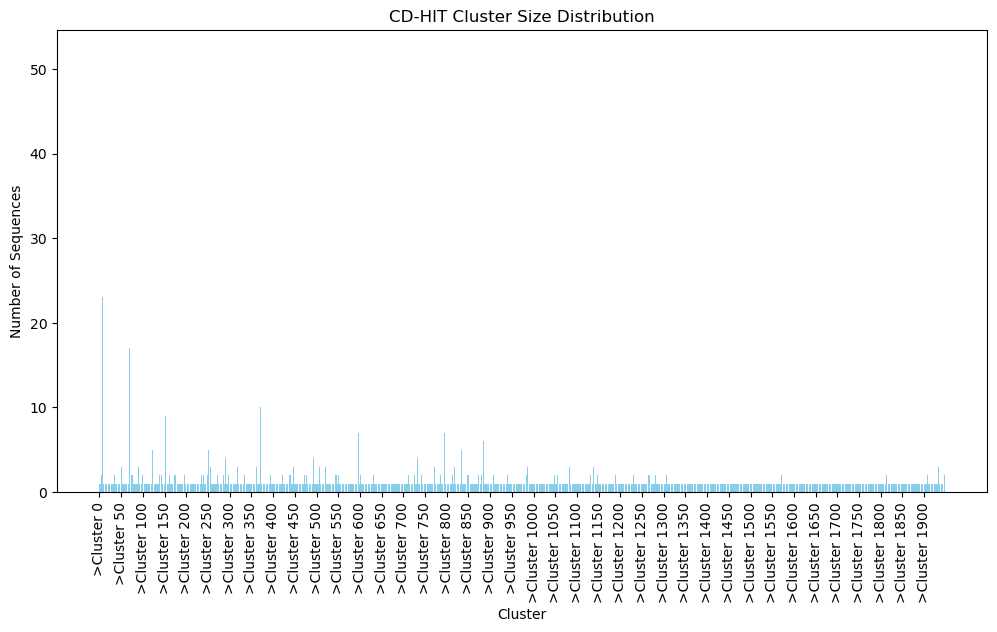

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Plot cluster sizes
plt.figure(figsize=(12, 6))  # Increase figure size

# Plot bar chart
plt.bar(df_summary["Cluster"], df_summary["Number of Sequences"], color='skyblue')

# Show only every nth label to reduce clutter
n = 50  # Adjust this number as needed
plt.xticks(np.arange(0, len(df_summary["Cluster"]), step=n), 
           df_summary["Cluster"][::n], 
           rotation=90)  # Rotate labels

# Axis labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Sequences")
plt.title("CD-HIT Cluster Size Distribution")

plt.show()


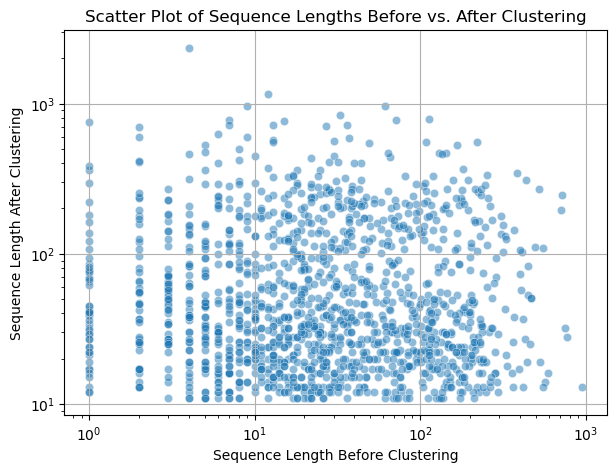

In [191]:
import pandas as pd
import seaborn as sns

# Function to get sequence lengths from a FASTA file
def get_sequence_lengths(fasta_file):
    lengths = []
    with open(fasta_file, "r") as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    lengths.append(len(seq))
                seq = ""
            else:
                seq += line.strip()
        if seq:
            lengths.append(len(seq))
    return lengths

# Get sequence lengths before and after clustering
before_lengths = get_sequence_lengths("step1/translated_proteins.fasta")
after_lengths = get_sequence_lengths("step2/representative_proteins.fasta")

# Create a DataFrame
df_lengths = pd.DataFrame({"Before Clustering": before_lengths[:len(after_lengths)], 
                           "After Clustering": after_lengths})

# Scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df_lengths["Before Clustering"], y=df_lengths["After Clustering"], alpha=0.5)
plt.xlabel("Sequence Length Before Clustering")
plt.ylabel("Sequence Length After Clustering")
plt.title("Scatter Plot of Sequence Lengths Before vs. After Clustering")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.savefig("images/seq_length_before_after_proteins.png")
plt.show()


In [119]:
# Run CD-HIT for protein sequences (if applicable)
!cd-hit -i step1/translated_proteins.fasta -o step2/clustered_proteins.fasta -c 0.70 -n 3 -d 0

Program: CD-HIT, V4.8.1 (+OpenMP), Nov 12 2024, 10:35:24
Command: cd-hit -i step1/translated_proteins.fasta -o
         step2/clustered_proteins.fasta -c 0.70 -n 3 -d 0

Started: Sat Feb  8 02:27:48 2025
                            Output                              
----------------------------------------------------------------
Your word length is 3, using 5 may be faster!
total seq: 1817
longest and shortest : 2358 and 11
Total letters: 168514
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 1 X 16M = 16M
Table           : 1 X 0M = 0M
Miscellaneous   : 0M
Total           : 17M

Table limit with the given memory limit:
Max number of representatives: 2782481
Max number of word counting entries: 97859186

comparing sequences from          0  to       1817
.
     1817  finished       1416  clusters

Approximated maximum memory consumption: 18M
writing new database
writing clustering information
program completed !

Total CPU t

In [120]:
!head -n 20 step2/clustered_proteins.fasta.clstr

>Cluster 0
0	2358aa, >k141_2357594... *
>Cluster 1
0	198aa, >k141_9031299... at 77.78%
1	1160aa, >k141_4340043... *
>Cluster 2
0	956aa, >k141_966364... *
1	155aa, >k141_6822803... at 70.32%
>Cluster 3
0	198aa, >k141_2005421... at 78.79%
1	144aa, >k141_7802339... at 78.47%
2	956aa, >k141_1778842... *
>Cluster 4
0	836aa, >k141_118972... *
>Cluster 5
0	102aa, >k141_961282... at 85.29%
1	794aa, >k141_6564741... *
2	462aa, >k141_2734549... at 70.35%
>Cluster 6
0	775aa, >k141_3934590... *


In [121]:
!grep '>' step2/clustered_proteins.fasta | cut -d' ' -f1 | sed 's/>//' > step2/representative_proteins.txt
!seqkit grep -f step2/representative_proteins.txt step1/translated_proteins.fasta > step2/representative_proteins.fasta

[INFO] 1416 patterns loaded from file


In [122]:
# Print results
print("Clustered Contigs:")
print_file_head("step2/clustered_proteins.fasta")

print("\nRepresentative Sequences:")
print_file_head("step2/representative_proteins.fasta")


Clustered Contigs:
>k141_960819
IDDFEIKGDSSTVDDSVPALKDKYKSHFKFGTATVVDELTPKNTQQLILNQFNSLTIGNELKPDYLLDKDATL
>k141_3842622
DALLGGSARLISVSQAKNRGYYIPDNYRESYVPEINFNTVDEVMKICYNNGLKMRAHTLVWHSQTPSWFFRNNYAGNGGFVNQQTMDARLEMYVKTVMNHVYLNQYGSVVYAWDVANEILHAQNSGWEAVYGNNKVNATYVKKAFNYAYQTLEYFKLTDSVKLFYNDYNTYMVVNDAITLINYINQGKKVCAGIG
>k141_4162895
DIDVAHVVGNVQQQETACHRGLDVHAHVLPLVVEGEAHIRAAAPVADTAVQLARLGTLDGHCHLVGLARLQQDVVHGHELHLPGP
>k141_2561960
QAWYLCLQEGSSHCNADRRTTLGSGCATQGYVRALRYRLPLQPQDKALPFQK
>k141_6724776
AAVQNILKRDFAAVTFGNEMKHDAIVQSDGRYNFASADEMAGWADACGNDLFGHTLGWHSQQRRDYLDAVISKAVPNNDASLLQKNWNLEEGTLDGFVADGFKVISSLYDVFAGEYAAKAVSDGASLQMDAAIEADKAYDVSFWAKTLDAEGSVKIVSGEGQEAETPVSKSWNKYSVTIPVKAAGEFSYRLVASKDVVIDNIRVIGADGSSPSASFWTGNDLGGELVNDA

Representative Sequences:
>k141_960819
IDDFEIKGDSSTVDDSVPALKDKYKSHFKFGTATVVDELTPKNTQQLILNQFNSLTIGNE
LKPDYLLDKDATL
>k141_3842622
DALLGGSARLISVSQAKNRGYYIPDNYRESYVPEINFNTVDEVMKICYNNGLKMRAHTLV
WHSQTPSWFFRNNYAGNGGFVNQQTMDARLEMYVKTVMNHVYLNQYGSVVYAWDVANEIL
HAQNSGWEAVYGNNKVNATYV

In [123]:
import pandas as pd

# Read the clustering result file
clstr_file = "step2/clustered_proteins.fasta.clstr"

clusters = []
cluster_id = None

# Parse the clustering file
with open(clstr_file, "r") as f:
    for line in f:
        if line.startswith(">Cluster"):
            cluster_id = line.strip()
        else:
            clusters.append([cluster_id, line.strip()])

# Convert to Pandas DataFrame
df = pd.DataFrame(clusters, columns=["Cluster", "Sequence Info"])

# Display the table
df.head(20)  # Show the first 20 rows


,Cluster,Sequence Info
0,>Cluster 0,"0\t2358aa, >k141_2357594... *"
1,>Cluster 1,"0\t198aa, >k141_9031299... at 77.78%"
2,>Cluster 1,"1\t1160aa, >k141_4340043... *"
3,>Cluster 2,"0\t956aa, >k141_966364... *"
4,>Cluster 2,"1\t155aa, >k141_6822803... at 70.32%"
5,>Cluster 3,"0\t198aa, >k141_2005421... at 78.79%"
6,>Cluster 3,"1\t144aa, >k141_7802339... at 78.47%"
7,>Cluster 3,"2\t956aa, >k141_1778842... *"
8,>Cluster 4,"0\t836aa, >k141_118972... *"
9,>Cluster 5,"0\t102aa, >k141_961282... at 85.29%"


In [124]:
from collections import defaultdict

cluster_counts = defaultdict(int)

with open("step2/clustered_proteins.fasta.clstr", "r") as f:
    current_cluster = None
    for line in f:
        if line.startswith(">Cluster"):
            current_cluster = line.strip()
        else:
            cluster_counts[current_cluster] += 1

# Convert to Pandas DataFrame
df_summary = pd.DataFrame(cluster_counts.items(), columns=["Cluster", "Number of Sequences"])

# Display the summary table
df_summary.head(20)  # Show the first 20 rows


,Cluster,Number of Sequences
0,>Cluster 0,1
1,>Cluster 1,2
2,>Cluster 2,2
3,>Cluster 3,3
4,>Cluster 4,1
5,>Cluster 5,3
6,>Cluster 6,1
7,>Cluster 7,1
8,>Cluster 8,3
9,>Cluster 9,2


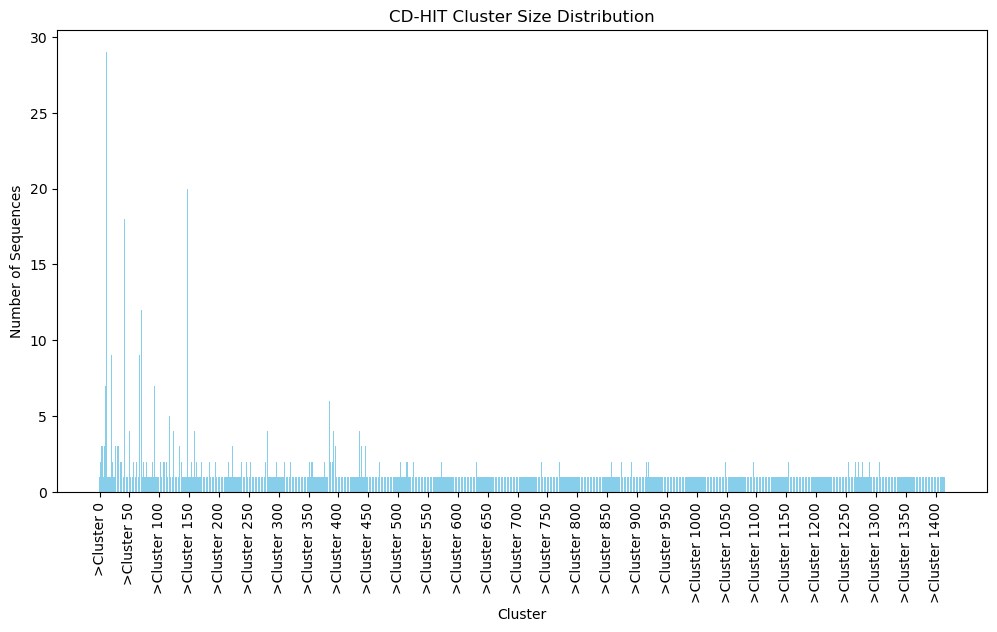

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Plot cluster sizes
plt.figure(figsize=(12, 6))  # Increase figure size

# Plot bar chart
plt.bar(df_summary["Cluster"], df_summary["Number of Sequences"], color='skyblue')

# Show only every nth label to reduce clutter
n = 50  # Adjust this number as needed
plt.xticks(np.arange(0, len(df_summary["Cluster"]), step=n), 
           df_summary["Cluster"][::n], 
           rotation=90)  # Rotate labels

# Axis labels and title
plt.xlabel("Cluster")
plt.ylabel("Number of Sequences")
plt.title("CD-HIT Cluster Size Distribution")

plt.show()


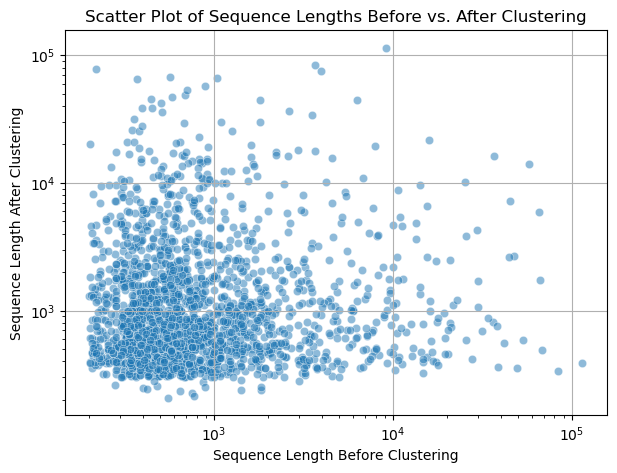

In [192]:
import pandas as pd
import seaborn as sns

# Function to get sequence lengths from a FASTA file
def get_sequence_lengths(fasta_file):
    lengths = []
    with open(fasta_file, "r") as f:
        seq = ""
        for line in f:
            if line.startswith(">"):
                if seq:
                    lengths.append(len(seq))
                seq = ""
            else:
                seq += line.strip()
        if seq:
            lengths.append(len(seq))
    return lengths

# Get sequence lengths before and after clustering
before_lengths = get_sequence_lengths("step1/filtered_contigs.fasta")
after_lengths = get_sequence_lengths("step2/representative_contigs.fasta")

# Create a DataFrame
df_lengths = pd.DataFrame({"Before Clustering": before_lengths[:len(after_lengths)], 
                           "After Clustering": after_lengths})

# Scatter plot
plt.figure(figsize=(7, 5))
sns.scatterplot(x=df_lengths["Before Clustering"], y=df_lengths["After Clustering"], alpha=0.5)
plt.xlabel("Sequence Length Before Clustering")
plt.ylabel("Sequence Length After Clustering")
plt.title("Scatter Plot of Sequence Lengths Before vs. After Clustering")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.savefig("images/seq_length_before_after_contigs.png")
plt.show()


# Step 3: Building a Conserved Domain Model and Filtering Sequences

### Multiple Sequence Alignment (MSA) using Clustal Omega
### **Multiple Sequence Alignment (MSA) using Clustal Omega**
In this step, we align the **clustered protein sequences** from Step 2 using **Clustal Omega**.  
Multiple sequence alignment helps identify **conserved regions** within the sequences, which is essential for building models like **PSSM (Position-Specific Scoring Matrix) or HMM (Hidden Markov Models)** in later steps.

**Command Breakdown:**
- `!clustalo` → Calls **Clustal Omega** for alignment.
- `-i step2/clustered_proteins.fasta` → Specifies the **input file** containing clustered protein sequences from Step 2.
- `-o step3/aligned_proteins.fasta` → Specifies the **output file** where aligned sequences will be saved.
- `--auto` → Automatically selects alignment parameters.
- `-v` → Enables **verbose mode** for additional details.

After running this step, the **aligned sequences** will be used for further analysis, such as building **conserved region models** in the next steps.

In [173]:
!clustalo -i step2/clustered_proteins.fasta -o step3/aligned_proteins.fasta --auto -v


Using 12 threads
Read 1416 sequences (type: Protein) from step2/clustered_proteins.fasta
Setting options automatically based on input sequence characteristics (might overwrite some of your options).
Using 109 seeds (chosen with constant stride from length sorted seqs) for mBed (from a total of 1416 sequences)
Calculating pairwise ktuple-distances...
Ktuple-distance calculation progress done. CPU time: 5.47u 0.01s 00:00:05.48 Elapsed: 00:00:02
mBed created 24 cluster/s (with a minimum of 1 and a soft maximum of 100 sequences each)
Distance calculation within sub-clusters done. CPU time: 5.67u 0.01s 00:00:05.68 Elapsed: 00:00:01
Guide-tree computation (mBed) done.
Progressive alignment progress done. CPU time: 590.50u 2.11s 00:09:52.61 Elapsed: 00:01:03
Alignment written to step3/aligned_proteins.fasta


In this step, we create a BLAST database from the clustered protein sequences obtained in Step 2.
This database will be used later for searching and identifying conserved regions in the xylanase protein sequences.

In [174]:
!makeblastdb -in step2/clustered_proteins.fasta -dbtype prot -out xylanase_db



Building a new DB, current time: 02/08/2025 03:36:58
New DB name:   /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
New DB title:  step2/clustered_proteins.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1416 sequences in 0.0223091 seconds.




In [196]:
!blastdbcmd -db xylanase_db -info


Database: step2/clustered_proteins.fasta
	1,416 sequences; 126,583 total residues

Date: Feb 8, 2025  3:36 AM	Longest sequence: 2,358 residues

BLASTDB Version: 5

Volumes:
	/home/amir/Documents/university/Semester9/bioinformatics/project2/xylanase_db


we read the aligned protein sequences from the multiple sequence alignment (MSA) and extract the first sequence to use as a query for further analysis.

In [175]:
from Bio import SeqIO

# Read the aligned protein sequences
records = list(SeqIO.parse("step3/aligned_proteins.fasta", "fasta"))

# Write the first sequence as the query
with open("step3/query.fasta", "w") as output_handle:
    SeqIO.write(records[0], output_handle, "fasta")

print("Query sequence saved in query.fasta")


Query sequence saved in query.fasta


### **Generating a Position-Specific Scoring Matrix (PSSM) using PSI-BLAST**
In this step, we use **PSI-BLAST** to analyze the **query sequence** against the **custom xylanase database** (`xylanase_db`) and generate a **PSSM (Position-Specific Scoring Matrix)**.

#### **Command Breakdown:**
- `!psiblast` → Calls the **PSI-BLAST** tool.
- `-db xylanase_db` → Specifies the **database** (`xylanase_db`) created in the previous step.
- `-query step3/query.fasta` → Uses the extracted **query sequence** from `step3/query.fasta`.
- `-num_iterations 3` → Runs **3 iterations** of PSI-BLAST to refine the PSSM.
- `-out_ascii_pssm xylanase.pssm` → Saves the **PSSM matrix** in a human-readable ASCII format as `xylanase.pssm`.

In [176]:
!psiblast -db xylanase_db -query step3/query.fasta -num_iterations 3 -out_ascii_pssm xylanase.pssm


PSIBLAST 2.16.0+


Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro A.
Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J.
Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of
protein database search programs", Nucleic Acids Res. 25:3389-3402.


Reference for compositional score matrix adjustment: Stephen F.
Altschul, John C. Wootton, E. Michael Gertz, Richa Agarwala,
Aleksandr Morgulis, Alejandro A. Schaffer, and Yi-Kuo Yu (2005)
"Protein database searches using compositionally adjusted
substitution matrices", FEBS J. 272:5101-5109.


Reference for composition-based statistics starting in round 2:
Alejandro A. Schaffer, L. Aravind, Thomas L. Madden, Sergei
Shavirin, John L. Spouge, Yuri I. Wolf, Eugene V. Koonin, and
Stephen F. Altschul (2001), "Improving the accuracy of PSI-BLAST
protein database searches with composition-based statistics and
other refinements", Nucleic Acids Res. 29:2994-3005.



Database: step2/clustered_proteins.fasta
           1

In this step, we process the aligned protein sequences to remove gaps ("-") introduced during multiple sequence alignment.
A cleaned query sequence is then saved for further analysis.

In [177]:
from Bio import SeqIO

# Read the aligned protein sequences
records = list(SeqIO.parse("step3/aligned_proteins.fasta", "fasta"))

# Remove gaps and ensure valid sequences
cleaned_records = []
for record in records:
    clean_seq = record.seq.replace("-", "")  # Remove all gaps
    if len(clean_seq) > 0:  # Ensure it's not empty after cleaning
        record.seq = clean_seq
        cleaned_records.append(record)

# Save the first valid sequence as query_cleaned.fasta
if cleaned_records:
    with open("step3/query_cleaned.fasta", "w") as output_handle:
        SeqIO.write(cleaned_records[0], output_handle, "fasta")
    print("Fixed query sequence saved as query_cleaned.fasta")
else:
    print("Error: No valid sequences found after removing gaps!")



Fixed query sequence saved as query_cleaned.fasta


In this step, we rerun PSI-BLAST using the cleaned query sequence (query_cleaned.fasta) to generate a PSSM (Position-Specific Scoring Matrix) while ensuring no gaps interfere with the analysis.

In [178]:
!psiblast -db xylanase_db -query step3/query_cleaned.fasta -num_iterations 3 -out_ascii_pssm step3/xylanase.pssm


PSIBLAST 2.16.0+


Reference: Stephen F. Altschul, Thomas L. Madden, Alejandro A.
Schaffer, Jinghui Zhang, Zheng Zhang, Webb Miller, and David J.
Lipman (1997), "Gapped BLAST and PSI-BLAST: a new generation of
protein database search programs", Nucleic Acids Res. 25:3389-3402.


Reference for compositional score matrix adjustment: Stephen F.
Altschul, John C. Wootton, E. Michael Gertz, Richa Agarwala,
Aleksandr Morgulis, Alejandro A. Schaffer, and Yi-Kuo Yu (2005)
"Protein database searches using compositionally adjusted
substitution matrices", FEBS J. 272:5101-5109.


Reference for composition-based statistics starting in round 2:
Alejandro A. Schaffer, L. Aravind, Thomas L. Madden, Sergei
Shavirin, John L. Spouge, Yuri I. Wolf, Eugene V. Koonin, and
Stephen F. Altschul (2001), "Improving the accuracy of PSI-BLAST
protein database searches with composition-based statistics and
other refinements", Nucleic Acids Res. 29:2994-3005.



Database: step2/clustered_proteins.fasta
           1

In [187]:
from Bio import AlignIO
import numpy as np
import pandas as pd

alignment = AlignIO.read("step3/aligned_proteins.fasta", "fasta")

num_positions = alignment.get_alignment_length()
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
freq_matrix = {aa: np.zeros(num_positions) for aa in amino_acids}

for col in range(num_positions):
    column = alignment[:, col]
    for aa in amino_acids:
        freq_matrix[aa][col] = column.count(aa) / len(column)

pssm = {aa: np.log2(freq_matrix[aa] + 1e-6) for aa in amino_acids}

pssm_df = pd.DataFrame(pssm)
print(pssm_df)

              A          C          D          E          F          G  \
0    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
1    -19.931569 -19.931569 -10.465564 -19.931569 -19.931569 -19.931569   
2    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3    -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
4    -19.931569 -19.931569 -19.931569 -10.465564 -19.931569 -19.931569   
...         ...        ...        ...        ...        ...        ...   
3852 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3853 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3854 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3855 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   
3856 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569 -19.931569   

              H          I          K          L          M          N  \
0    -19.931569 -19.931569 -19.931569

### Heatmap of PSSM Scores
A heatmap shows amino acid conservation across sequence positions.

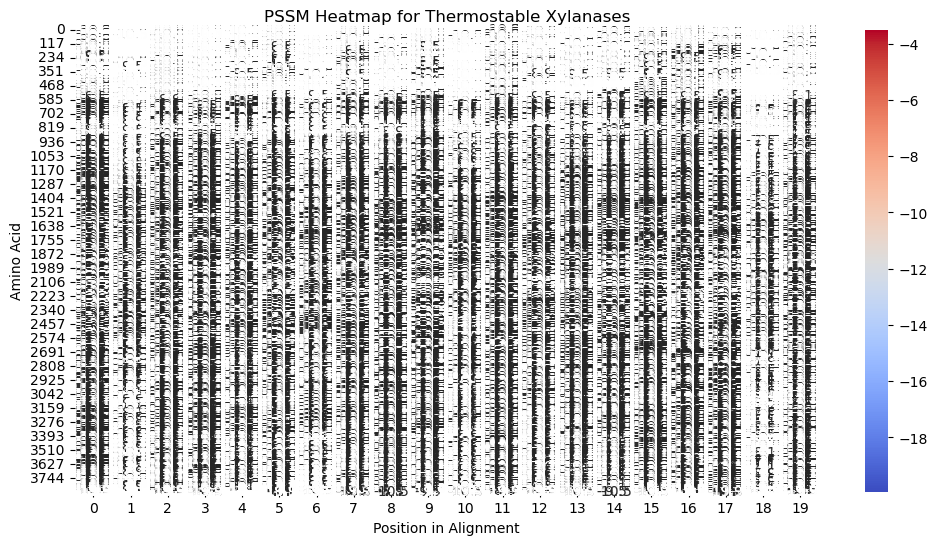

In [188]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.Align.substitution_matrices import Array

# Convert PSSM to numpy array
pssm_matrix = np.array(pssm_df)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pssm_matrix, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)
plt.xlabel("Position in Alignment")
plt.ylabel("Amino Acid")
plt.title("PSSM Heatmap for Thermostable Xylanases")
plt.savefig("images/pssm_heatmap.png")
plt.show()

### Distribution of Conservation Scores
This helps to understand the range of conservation scores.

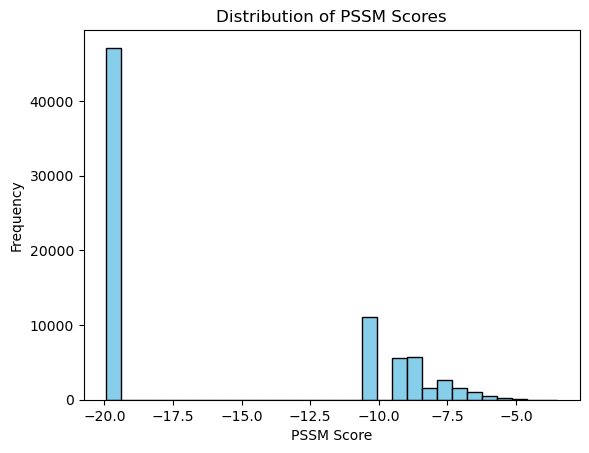

In [189]:
plt.hist(pssm_matrix.flatten(), bins=30, color="skyblue", edgecolor="black")
plt.xlabel("PSSM Score")
plt.ylabel("Frequency")
plt.title("Distribution of PSSM Scores")
plt.savefig("images/dist_pssm_score.png")
plt.show()

## Sequence Logo Visualization
A sequence logo shows conservation levels at each position.

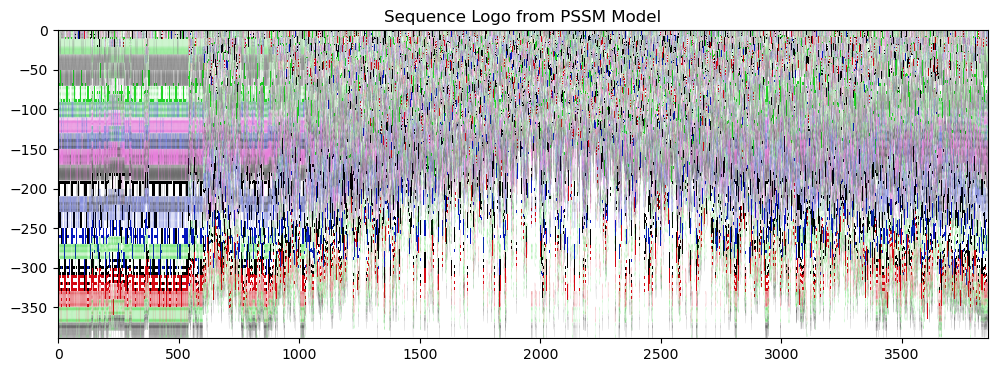

In [190]:
import logomaker
import pandas as pd

# Convert PSSM to pandas DataFrame
df_pssm = pd.DataFrame(pssm_matrix, columns=["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"])

# Generate sequence logo
logomaker.Logo(df_pssm, color_scheme="weblogo_protein", figsize=(12, 4))
plt.title("Sequence Logo from PSSM Model")
plt.savefig("images/seq_logo_pssm.png")
plt.show()

In [194]:
!weblogo -f step3/aligned_proteins.fasta -o images/conserved_motif.png --format PNG --size large --title "Conserved Motif in Xylanase Proteins"

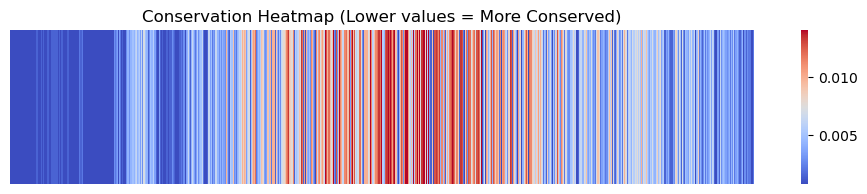

In [193]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import AlignIO

# Load aligned sequences
alignment = AlignIO.read("step3/aligned_proteins.fasta", "fasta")

# Compute conservation score for each column
num_sequences = len(alignment)
alignment_length = len(alignment[0])

conservation_scores = []
for i in range(alignment_length):
    column = [record.seq[i] for record in alignment]
    unique_residues = set(column) - {"-"}  # Exclude gaps
    score = len(unique_residues) / num_sequences
    conservation_scores.append(score)

# Create heatmap
plt.figure(figsize=(12, 2))
sns.heatmap([conservation_scores], cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True)
plt.title("Conservation Heatmap (Lower values = More Conserved)")
plt.savefig("images/conservation_heatmap.png")
plt.show()


The heatmap above represents the conservation scores of amino acid positions across the multiple sequence alignment (MSA) of xylanase proteins. Each column corresponds to a specific position in the alignment, while the color intensity reflects the level of conservation. Dark blue regions indicate highly conserved positions, suggesting that these residues are functionally or structurally important, potentially forming the catalytic core or active site of the enzyme. Red regions represent highly variable positions, which are likely located in loop regions, surface-exposed areas, or non-essential segments that tolerate mutations. The central region, which exhibits higher variation (red segments), may correspond to subfamily-specific modifications or flexible loops involved in substrate binding. This heatmap provides insights into which residues are critical for enzyme function and can help in designing further experiments, such as site-directed mutagenesis or structural modeling.

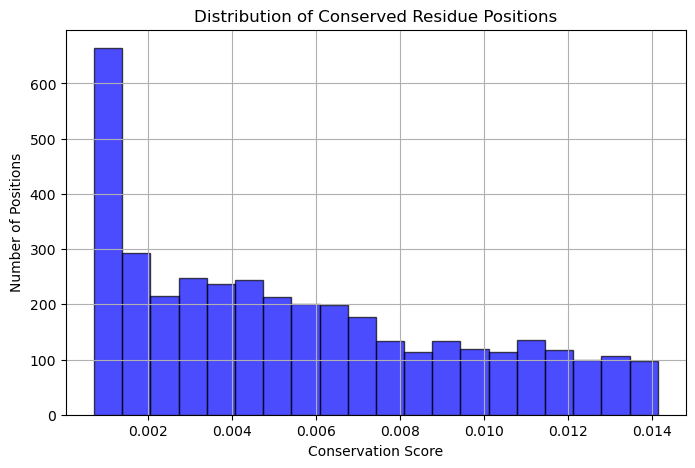

In [195]:
plt.figure(figsize=(8, 5))
plt.hist(conservation_scores, bins=20, color="blue", edgecolor="black", alpha=0.7)
plt.xlabel("Conservation Score")
plt.ylabel("Number of Positions")
plt.title("Distribution of Conserved Residue Positions")
plt.grid(True)
plt.savefig("images/dist_conserved_res_pos.png")
plt.show()

### **Analysis of the Conservation Score Distribution**
The histogram above illustrates the **distribution of conservation scores** across all amino acid positions in the multiple sequence alignment (MSA) of xylanase proteins. The **X-axis represents the conservation score**, with lower values indicating **higher conservation**, while the **Y-axis represents the number of positions** at each conservation level. 

From this distribution, we observe that:
- A **large number of residues (~650 positions) have very low conservation scores (≤0.002)**, indicating that these positions are **highly conserved** across the dataset. These residues are likely **critical for enzyme function**, such as those involved in **catalysis, substrate binding, or structural stability**.
- The **rightward tail of the histogram** shows **fewer residues with higher variability**, suggesting that most amino acids in the dataset are **functionally constrained**.
- The presence of **some highly variable positions (conservation score >0.01)** suggests the existence of **subfamily-specific modifications** or **flexible regions** that allow for adaptation to different environmental conditions.

This distribution aligns with expectations for **functionally important enzymes**, where a subset of residues is **highly conserved**, while others are **more flexible and variable**.



# HMM

In [179]:
!hmmbuild xylanase.hmm step3/aligned_proteins.fasta

# hmmbuild :: profile HMM construction from multiple sequence alignments
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# input alignment file:             step3/aligned_proteins.fasta
# output HMM file:                  xylanase.hmm
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# idx name                  nseq  alen  mlen eff_nseq re/pos description
#---- -------------------- ----- ----- ----- -------- ------ -----------
1     aligned_proteins      1416  3857   731   222.79  0.590 

# CPU time: 0.56u 0.00s 00:00:00.56 Elapsed: 00:00:00.56


In this step, we use HMMER’s hmmsearch tool to scan the clustered protein sequences from Step 2 against a Hidden Markov Model (HMM) of xylanases.
This helps filter sequences that match the conserved domain model.

In [182]:
!hmmsearch --tblout step3/filtered_xylanase_hmm.txt xylanase.hmm step2/clustered_proteins.fasta

# hmmsearch :: search profile(s) against a sequence database
# HMMER 3.4 (Aug 2023); http://hmmer.org/
# Copyright (C) 2023 Howard Hughes Medical Institute.
# Freely distributed under the BSD open source license.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# query HMM file:                  xylanase.hmm
# target sequence database:        step2/clustered_proteins.fasta
# per-seq hits tabular output:     step3/filtered_xylanase_hmm.txt
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Query:       aligned_proteins  [M=731]
Scores for complete sequences (score includes all domains):
   --- full sequence ---   --- best 1 domain ---    -#dom-
    E-value  score  bias    E-value  score  bias    exp  N  Sequence     Description
    ------- ------ -----    ------- ------ -----   ---- --  --------     -----------
          0 1058.2  40.9   2.1e-280  928.4  30.7    2.2  2  k141_2357594  
    1.1e-88  294.6   3.2    1.3e-88  294.4   3.2    1.

In this step, we parse the output file from hmmsearch (filtered_xylanase_hmm.txt) to extract sequence IDs of proteins that match the xylanase HMM model.

In [183]:
import re

# Read HMMER output file
hmm_results = "step3/filtered_xylanase_hmm.txt"  # Adjust if filename is different
seq_ids = set()

with open(hmm_results, "r") as f:
    for line in f:
        if not line.startswith("#"):  # Skip comments
            cols = line.split()
            seq_id = cols[0]  # Extract the sequence ID
            seq_ids.add(seq_id)

print(f"Extracted {len(seq_ids)} sequence IDs from HMM results.")


Extracted 36 sequence IDs from HMM results.


In this step, we filter the clustered protein sequences from Step 2 and extract only those that were identified in the HMM search results.

In [185]:
from Bio import SeqIO

# Load the identified sequence IDs from HMM search
hmm_ids = set(seq_ids)

# Read clustered proteins and extract matching sequences
input_fasta = "step2/clustered_proteins.fasta"
output_fasta = "step3/final_xylanase_candidates.fasta"

with open(output_fasta, "w") as output_handle:
    for record in SeqIO.parse(input_fasta, "fasta"):
        if record.id in hmm_ids:
            SeqIO.write(record, output_handle, "fasta")

print(f"Final filtered sequences saved in {output_fasta}")

Final filtered sequences saved in step3/final_xylanase_candidates.fasta


In [186]:
from Bio import SeqIO

output_fasta = "step3/final_xylanase_candidates.fasta"

print("Final Xylanase Candidates:")
print("=" * 30)

for record in SeqIO.parse(output_fasta, "fasta"):
    print(f"ID: {record.id}")
    print(f"Length: {len(record.seq)} amino acids")
    print(f"Sequence:\n{record.seq}\n")
    print("-" * 30)


Final Xylanase Candidates:
ID: k141_966364
Length: 956 amino acids
Sequence:
VEGENIIPNGNFDSEDVSMWQAEAGEAKISTATADEPIFDDVKTYGVINSRTRSYDCIAIDVTDLVTNGSTYAFTFYAMLSDDYEGAPADQRQVDFAPYITSGGDTSYLGSYSAELSGDVSQQLTPGKWTKFSGTFKVASAGSLDKVVIRLLEQGTNYGEGDCVKGEYYVTGVSLIDMNVATGSIEEGIPALRDSMEADFGKDFIAGTSLSGSEINDSVLMSLVEKHFNAITLGNELKPDAIFGYSNDKVPMTETVHLGGEKLVVPKLDFSRAERYLDFILEWNEANPDKQRKVRGHVLVWHSQTPEWFFHENYETAKPYASVELMNLRQEWYIKSVLEHFVGSDSPYKDLFYGWDVVNEAVSDSTGTYRSDKENSSWWAVYGSEEFIKNAFVYANKYAPETLDLYYNDYNDCTPGKVEGIVKLLKAVKETEGARISGMGMQGHYDIDYPTADAFKDAARKYGEVVGKVMLTEVDLKSSSTYDGTELTLQDEYTKQAYKYKEIYDCMKELEAEGKVKVAGIVFWGVIDGNSWLQAYTGVGGGVTDGSPQCPLLFDDDYHAKPAYWAFVDPTKLAPMMHSVSILQAPVDSLDDASLIEFDDIASTFAAIWNDGQIQFKVNVVDYTDDASDKVSVYLDRYNSKSEGIKTRCVEVSRSDCEKTDTGYVAYVNVPMEEAANNVVAGFDIVITDGNDKYAFNDKTMTQESSSKYFAEMMLKPFMYIPMGKALIDGEYDDAYNGAVEVVLGNANDSPKATATAKLLWDQDFLYVYADIKDADLNKANEEPHEQDSLEVFIDETNSKADSYNAATKQYRINFDNEHSFNGDKCTEENLKTVTKKVDGGYIVEGAFKWTEVKPKEGDHIGIELQINDADASGARVGTLTWNDLTNQCWSSPSCFGTAVFTKEAEYVPTVEEAEPTEAVETA